In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# SPCA libraries
from SPCA import frameDiagnosticsBackend
from SPCA import Photometry_Aperture as APhotometry
from SPCA import Photometry_PSF as PSFPhotometry
from SPCA import Photometry_Companion as CPhotometry
from SPCA import Photometry_PLD as PLDPhotometry

In [3]:
# The names of all the planets you want analyzed (without spaces)
planet = 'KELT-16b'
channel = 'ch2'

# Were the data taken in subarray mode?
subarray = True

# The number of CPU threads you want to use for running photometry methods in parallel
ncpu = 3

#folder containing data from each planet
basepath = '/home/taylor/Documents/Research/spitzer/MEGA/'

## Parameters to set how you want your photometry done

In [4]:
#################
# General settings
#################

# Whether or not to bin data points together
bin_data = True
# Number of data points to bin together
bin_size = 64

# Do you want to oversample frames before performing aperture photometry?
# Don't recommend a value larger than 2
oversamp = False
scale = 2

# Do you want the frame diagnostics to automatically remove certain frames within a data cube?
# Doesn't work for fullframe photometry!
allowIgnoreFrames = [True, False]

# The number of sigma a frame's median value must be off from the median frame in order to be added to ignore_frames
nsigma = 4

# An array-like object where each element is an array-like object with the RA and DEC coordinates of a nearby star which should be masked out when computing background subtraction.
maskStars = None

# Whether to use Aperture photometry, PSF photometry, or PLD photometry
photometryMethods = ['Aperture', 'PSF', 'PLD']

#################
# The purpose of this stack is to remove artifacts from bad background subtraction from the Spitzer data pipeline
# If set to True, the following option requires contacting someone from IPAC in order to get your correction stack.
# In general, this stack doesn't significantly impact the results, so we have not implemented this ourselves.
#################
# If True, the correction stack must be in the folder basepath+'/Calibration'
# The correction stack must also have the name format 'correction_stack_for_BCDs_that_used_SPITZER_I#_SDARK#'
#    where # should be replaced with the channel number, and SDARK# should be replaced with a string that 
#    specifies which sdark file was used. This can be found within the cal directory if you downloaded that
#    from SHA.
addStacks = [False]

#################
# Settings for aperture photometry
# Can leave untouched if not using aperture photometry; these settings would be ignored
#################

# Do you want to only save the best aperture photometry method?
# This will save quite a bit of hard drive space
onlyBest = True

# Aperture radii to try
radii = np.linspace(2.,6.,21,endpoint=True)

# Aperture shape to try. Possible aperture shapes are 'Circular', 'Elliptical', 'Rectangular'
shapes = ['Circular']

# Aperture edges to try. Possible options are 'Exact' (pixels are weighted by the fraction that lies within the aperture), 'Hard' (pixel is only included if its centre is in the aperture), and 'Soft' (approximates exact)
edges = ['Exact', 'Hard']

# Whether or not to keep the aperture centred at the centroid (otherwise keeps centred at the middle of the subarray)
moveCentroids = [True]

# How wide should the boxcar filter be that smooths the raw data to select the best aperture
highpassWidth = 5*64

#################
# Settings for PLD
# Can leave untouched if not using PLD; these settings would be ignored
#################

# Size of PLD stamp to use (only 3 and 5 currently supported)
stamp_sizes = [3, 5]

Starting PSF photometry!
	Getting frames, masking bad frames... Sigma clipping... Subtracting background... Frames loaded!
	* Removing ignoreFrames
	Fitting Gaussians...


100%|██████████| 44928/44928 [03:17<00:00, 227.63it/s]


	Saving... 

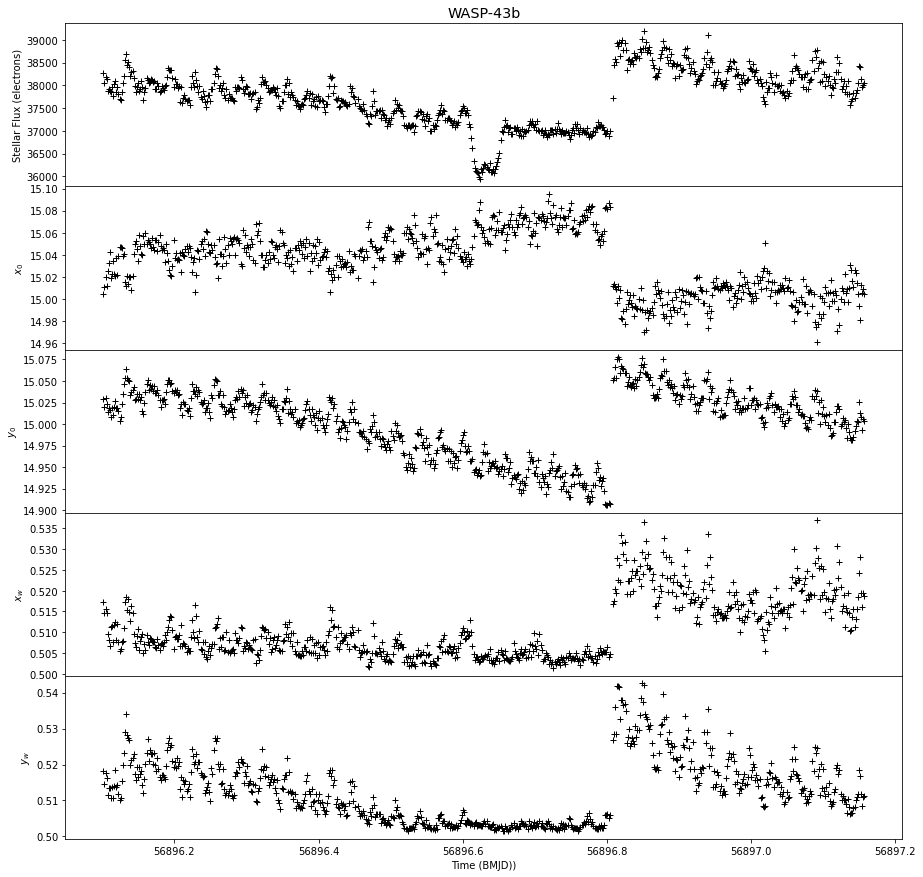

	* Not removing ignoreFrames
	Fitting Gaussians...


100%|██████████| 44928/44928 [03:14<00:00, 231.26it/s]


	Saving... 

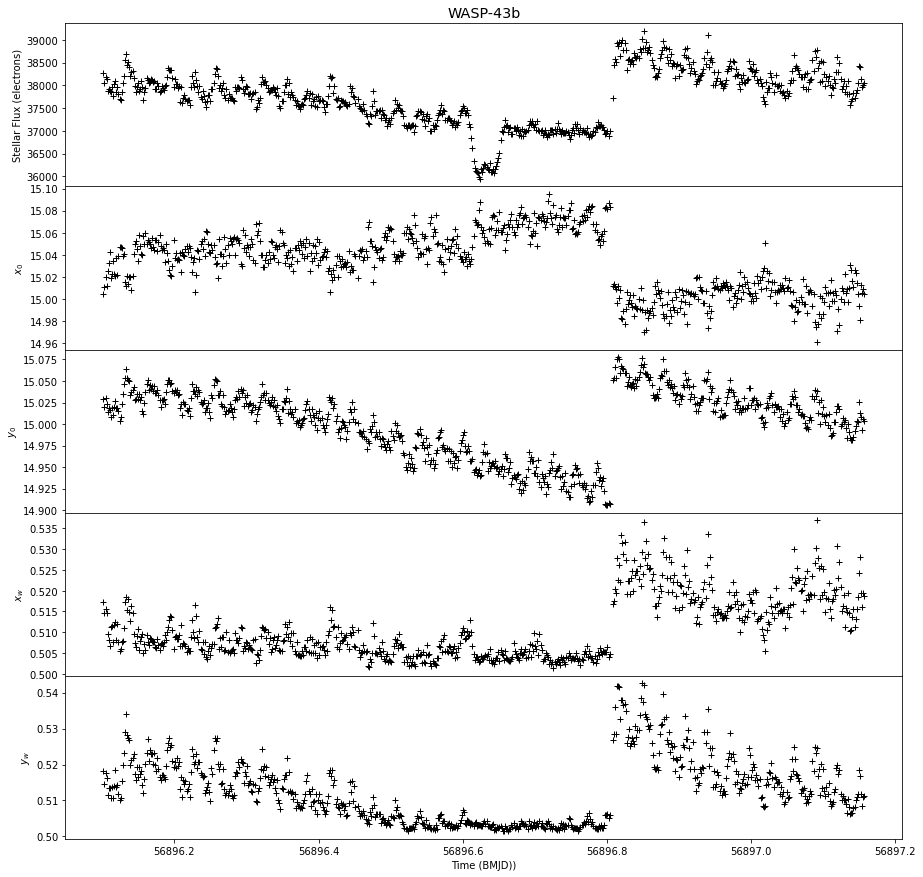

Done.
Done!


In [5]:
#bit of AOR to pick out which folders contain AORs that should be analyzed
with open(basepath+planet+'/analysis/aorSnippet.txt', 'r') as file:
    AOR_snip = file.readline().strip()

for addStack in addStacks:
    if subarray and (True in allowIgnoreFrames):
        # Perform frame diagnostics to figure out which frames within a datacube are consistently bad
        print('Analysing', channel, 'for systematically bad frames...')
        ignoreFrames = frameDiagnosticsBackend.run_diagnostics(planet, channel, AOR_snip,
                                                               basepath, addStack, highpassWidth, nsigma,
                                                               ncpu, showPlot=True, savePlot=True)
    else:
        ignoreFrames = []
    
    # Try all of the different photometry methods
    for photometryMethod in photometryMethods:
        if photometryMethod.lower()=='aperture':
            print('Starting Aperture photometry!')
            APhotometry.get_lightcurve(basepath, AOR_snip, channel, planet,
                                       True, onlyBest, highpassWidth,
                                       bin_data, bin_size, True, True,
                                       oversamp, scale, True, True, radii, edges,
                                       addStack, ignoreFrames, allowIgnoreFrames,
                                       maskStars, moveCentroids, ncpu)

        elif photometryMethod.lower()=='psf':
            print('Starting PSF photometry!')
            PSFPhotometry.get_lightcurve(basepath, AOR_snip, channel, planet,
                                         True, highpassWidth, bin_data, bin_size, True, True,
                                         oversamp, scale, True, True,
                                         addStack, ignoreFrames, allowIgnoreFrames,
                                         maskStars, ncpu)

        elif photometryMethod.lower()=='pld':
            print('Starting PLD photometry!')
            PLDPhotometry.get_lightcurve(basepath, AOR_snip, channel, planet,
                                         stamp_sizes, True, highpassWidth, bin_data, bin_size,
                                         True, True, addStack, ignoreFrames, allowIgnoreFrames,
                                         maskStars, ncpu)
            if len(ignoreFrames)!=0:
                # Write down what frames should be ignored in case not doing PLDAper
                with open(basepath+planet+'/analysis/'+channel+'/PLD_ignoreFrames.txt', 'w') as file:
                    file.write('IgnoreFrames = '+str(ignoreFrames)[1:-1]+'\n')
            
print('Done!')